In [1]:
# 划分训练集和验证集
import shutil
import os
from PIL import Image
train_dir = '/home/aistudio/work/11分类/trainImages'
eval_dir = '/home/aistudio/work/11分类/evalImages'
train_list_path = '/home/aistudio/数据集/11分类/train_list.txt'
target_path = "/home/aistudio/数据集/11分类/"

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(eval_dir):
    os.mkdir(eval_dir) 

with open(train_list_path, 'r') as f:
    data = f.readlines()
    for i in range(len(data)):
        img_path = data[i].split('\t')[0]
        class_label = data[i].split('\t')[1][:-1]
        if i % 5 == 0: # 每5张图片取一个做验证数据
            eval_target_dir = os.path.join(eval_dir, str(class_label)) 
            eval_img_path = os.path.join(target_path, img_path)
            if not os.path.exists(eval_target_dir):
                os.mkdir(eval_target_dir)  
            shutil.copy(eval_img_path, eval_target_dir)                         
        else:
            train_target_dir = os.path.join(train_dir, str(class_label)) 
            train_img_path = os.path.join(target_path, img_path)                     
            if not os.path.exists(train_target_dir):
                os.mkdir(train_target_dir)
            shutil.copy(train_img_path, train_target_dir) 

    print ('划分训练集和验证集完成！')

划分训练集和验证集完成！


In [2]:
import os
import numpy as np
import paddle
from paddle.io import Dataset
from paddle.vision.datasets import DatasetFolder, ImageFolder
from paddle.vision.transforms import Compose, Resize, Normalize, Transpose

class FaceDataset(Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, mode='train'):
        """
        步骤二：实现构造函数，定义数据读取方式，划分训练和测试数据集
        """
        super(FaceDataset, self).__init__()
        train_image_dir = '/home/aistudio/work/11分类/trainImages'
        eval_image_dir = '/home/aistudio/work/11分类/evalImages'

        transform_train = Compose([Resize(size=(224, 224)), Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'), Transpose()])
        transform_eval = Compose([Resize(size=(224, 224)), Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'), Transpose()])
        train_data_folder = DatasetFolder(train_image_dir, transform=transform_train)
        eval_data_folder = DatasetFolder(eval_image_dir, transform=transform_eval)
        self.mode = mode
        if self.mode  == 'train':
            self.data = train_data_folder
        elif self.mode  == 'eval':
            self.data = eval_data_folder
        elif self.mode  == 'test':
            self.data = test_data_folder

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        data = np.array(self.data[index][0]).astype('float32')

        if self.mode  == 'test':
            return data
        else:
            label = np.array([self.data[index][1]]).astype('int64')

            return data, label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.data)

train_dataset = FaceDataset(mode='train')
val_dataset = FaceDataset(mode='eval')

In [3]:

from paddle.vision.models import resnet50

model = resnet50(pretrained=False, num_classes=11) # 初始化模型组网

W0329 15:15:22.519207   301 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0329 15:15:22.524696   301 device_context.cc:422] device: 0, cuDNN Version: 7.6.


In [4]:
optimizer = paddle.optimizer.Momentum(learning_rate=0.001,
                                      momentum=0.9,
                                      parameters=model.parameters()) # 初始化优化器

In [5]:
def reader_prepare(dataset):
    def reader():
        counter_ = -1
        for sample, label in dataset:
            counter_ += 1
            yield counter_, (sample / 255.0).astype(np.float32), int(label)

    return reader

BATCH_SIZE = 16
train_reader = paddle.batch(reader_prepare(train_dataset), batch_size=BATCH_SIZE) # 初始化数据加载器


In [6]:
!pip install interpretdl

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 89 kB 4.1 MB/s             
     |████████████████████████████████| 22.3 MB 2.7 MB/s            
     |████████████████████████████████| 13.5 MB 2.2 MB/s            
     |████████████████████████████████| 178 kB 2.4 MB/s            
     |████████████████████████████████| 6.4 MB 3.0 MB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blackhole 1.0.1 requires numpy<=1.19.5, but you have numpy 1.20.3 which is incompatible.
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [7]:
import interpretdl as it
# fe = it.ForgettingEventsInterpreter(model, True) # 初始化对训练数据解释的算法

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [29]:
import paddle

ResNet18 = paddle.vision.models.resnet34(pretrained=True, num_classes=11) # 使用预训练模型


In [25]:
import paddle
import math
import paddle.fluid as fluid
from paddle import nn

class CBAM_Module(nn.Layer):  
    def __init__(self, channels, reduction=16):  
        super(CBAM_Module, self).__init__()  
        self.avg_pool = nn.AdaptiveAvgPool2D(output_size=1)  
        self.max_pool = nn.AdaptiveMaxPool2D(output_size=1)  
        self.fc1 = nn.Conv2D(in_channels=channels, out_channels=channels // reduction, kernel_size=1, padding=0)  
        self.relu = nn.ReLU()  
        self.fc2 = nn.Conv2D(in_channels=channels // reduction, out_channels=channels, kernel_size=1, padding=0)  

        self.sigmoid_channel = nn.Sigmoid()  
        self.conv_after_concat = nn.Conv2D(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3)  
        self.sigmoid_spatial = nn.Sigmoid()  

    def forward(self, x):  
        # Channel Attention Module  
        module_input = x  
        avg = self.relu(self.fc1(self.avg_pool(x)))  
        avg = self.fc2(avg)  
        mx = self.relu(self.fc1(self.max_pool(x)))  
        mx = self.fc2(mx)  
        x = avg + mx  
        x = self.sigmoid_channel(x)  

        # Spatial Attention Module  
        x = module_input * x  
        module_input = x  
        avg = paddle.mean(x, axis=1, keepdim=True)  
        mx = paddle.argmax(x, axis=1, keepdim=True)
        mx = paddle.cast(mx, 'float32')
        x = paddle.concat([avg, mx], axis=1)
        x = self.conv_after_concat(x)  
        x = self.sigmoid_spatial(x)  
        x = module_input * x  

        return x  

In [26]:
import paddle
import paddle.nn as nn
from paddle.utils.download import get_weights_path_from_url

__all__ = [
    'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'
]

model_urls = {
    'resnet18': ('https://paddle-hapi.bj.bcebos.com/models/resnet18.pdparams',
                 'cf548f46534aa3560945be4b95cd11c4'),
    'resnet34': ('https://paddle-hapi.bj.bcebos.com/models/resnet34.pdparams',
                 '8d2275cf8706028345f78ac0e1d31969'),
    'resnet50': ('https://paddle-hapi.bj.bcebos.com/models/resnet50.pdparams',
                 'ca6f485ee1ab0492d38f323885b0ad80'),
    'resnet101': ('https://paddle-hapi.bj.bcebos.com/models/resnet101.pdparams',
                  '02f35f034ca3858e1e54d4036443c92d'),
    'resnet152': ('https://paddle-hapi.bj.bcebos.com/models/resnet152.pdparams',
                  '7ad16a2f1e7333859ff986138630fd7a'),
}


class BasicBlock(nn.Layer):
    expansion = 1

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2D

        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock")

        self.conv1 = nn.Conv2D(
            inplanes, planes, 3, padding=1, stride=stride, bias_attr=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2D(planes, planes, 3, padding=1, bias_attr=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleneckBlock(nn.Layer):

    expansion = 4

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer=None):
        super(BottleneckBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2D
        width = int(planes * (base_width / 64.)) * groups

        self.conv1 = nn.Conv2D(inplanes, width, 1, bias_attr=False)
        self.bn1 = norm_layer(width)

        self.conv2 = nn.Conv2D(
            width,
            width,
            3,
            padding=dilation,
            stride=stride,
            groups=groups,
            dilation=dilation,
            bias_attr=False)
        self.bn2 = norm_layer(width)

        self.conv3 = nn.Conv2D(
            width, planes * self.expansion, 1, bias_attr=False)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Layer):
    def __init__(self, block, depth, num_classes=1000, with_pool=True):
        super(ResNet, self).__init__()
        layer_cfg = {
            18: [2, 2, 2, 2],
            34: [3, 4, 6, 3],
            50: [3, 4, 6, 3],
            101: [3, 4, 23, 3],
            152: [3, 8, 36, 3]
        }
        layers = layer_cfg[depth]
        self.num_classes = num_classes
        self.with_pool = with_pool
        self._norm_layer = nn.BatchNorm2D

        self.inplanes = 64
        self.dilation = 1

        self.conv1 = nn.Conv2D(
            3,
            self.inplanes,
            kernel_size=7,
            stride=2,
            padding=3,
            bias_attr=False)
        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU()
        self.CBAM_Module1 = CBAM_Module(channels=self.inplanes)
        self.maxpool = nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.CBAM_Module2 = CBAM_Module(channels=512)
        if with_pool:
            self.avgpool = nn.AdaptiveAvgPool2D((1, 1))

        if num_classes > 0:
            self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2D(
                    self.inplanes,
                    planes * block.expansion,
                    1,
                    stride=stride,
                    bias_attr=False),
                norm_layer(planes * block.expansion), )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, 1, 64,
                  previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.CBAM_Module1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.CBAM_Module2(x)

        if self.with_pool:
            x = self.avgpool(x)

        if self.num_classes > 0:
            x = paddle.flatten(x, 1)
            x = self.fc(x)

        return x


def _resnet(arch, Block, depth, pretrained, **kwargs):
    model = ResNet(Block, depth, **kwargs)
    if pretrained:
        assert arch in model_urls, "{} model do not have a pretrained model now, you should set pretrained=False".format(
            arch)
        weight_path = get_weights_path_from_url(model_urls[arch][0],
                                                model_urls[arch][1])

        param = paddle.load(weight_path)
        model.set_dict(param)

    return model


def resnet18(pretrained=False, **kwargs):
    return _resnet('resnet18', BasicBlock, 18, pretrained, **kwargs)


def resnet34(pretrained=False, **kwargs):
    return _resnet('resnet34', BasicBlock, 34, pretrained, **kwargs)


def resnet50(pretrained=False, **kwargs):
    return _resnet('resnet50', BottleneckBlock, 50, pretrained, **kwargs)


def resnet101(pretrained=False, **kwargs):
    return _resnet('resnet101', BottleneckBlock, 101, pretrained, **kwargs)


def resnet152(pretrained=False, **kwargs):
    return _resnet('resnet152', BottleneckBlock, 152, pretrained, **kwargs)

In [27]:
CBAM_ResNet18 = resnet34(pretrained=True, num_classes=11)

In [30]:

ResNet18 = paddle.Model(ResNet18)
CBAM_ResNet18 = paddle.Model(CBAM_ResNet18)

In [31]:
# 调用飞桨框架的VisualDL模块，保存信息到目录中。
callback = paddle.callbacks.VisualDL(log_dir='ResNet_50_11_log_dir')
CBAMcallback = paddle.callbacks.VisualDL(log_dir='CBAM_ResNet_50_11_log_dir')

def create_optim(parameters):
    step_each_epoch = len(train_dataset) // 16
    lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.01,
                                                  T_max=step_each_epoch * 20)

    return paddle.optimizer.Momentum(learning_rate=lr,
                                     parameters=parameters,
                                     weight_decay=paddle.regularizer.L2Decay(0.002))

# 两个模型使用相同训练配置
ResNet18.prepare(create_optim(ResNet18.parameters()),  # 优化器
              paddle.nn.CrossEntropyLoss(),        # 损失函数
              paddle.metric.Accuracy(topk=(1, 5))) # 评估指标

CBAM_ResNet18.prepare(create_optim(CBAM_ResNet18.parameters()),  # 优化器
              paddle.nn.CrossEntropyLoss(),        # 损失函数
              paddle.metric.Accuracy(topk=(1, 5))) # 评估指标

In [32]:


ResNet18.summary((16, 3, 512, 512))


--------------------------------------------------------------------------------
    Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-328      [[16, 3, 512, 512]]   [16, 64, 256, 256]       9,408     
  BatchNorm2D-304    [[16, 64, 256, 256]]  [16, 64, 256, 256]        256      
      ReLU-128       [[16, 64, 256, 256]]  [16, 64, 256, 256]         0       
    MaxPool2D-8      [[16, 64, 256, 256]]  [16, 64, 128, 128]         0       
     Conv2D-329      [[16, 64, 128, 128]]  [16, 64, 128, 128]      36,864     
  BatchNorm2D-305    [[16, 64, 128, 128]]  [16, 64, 128, 128]        256      
      ReLU-129       [[16, 64, 128, 128]]  [16, 64, 128, 128]         0       
     Conv2D-330      [[16, 64, 128, 128]]  [16, 64, 128, 128]      36,864     
  BatchNorm2D-306    [[16, 64, 128, 128]]  [16, 64, 128, 128]        256      
   BasicBlock-65     [[16, 64, 128, 128]]  [16, 64, 128, 128]         0       
     Conv2D-331      [[16, 64, 128, 128]]  [16, 64

{'total_params': 21307339, 'trainable_params': 21273291}

In [33]:
CBAM_ResNet18.summary((16, 3, 512, 512))

--------------------------------------------------------------------------------
    Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-286      [[16, 3, 512, 512]]   [16, 64, 256, 256]       9,408     
  BatchNorm2D-268    [[16, 64, 256, 256]]  [16, 64, 256, 256]        256      
      ReLU-109       [[16, 64, 256, 256]]  [16, 64, 256, 256]         0       
AdaptiveAvgPool2D-13 [[16, 64, 256, 256]]    [16, 64, 1, 1]           0       
     Conv2D-287        [[16, 64, 1, 1]]      [16, 4, 1, 1]           260      
      ReLU-110         [[16, 4, 1, 1]]       [16, 4, 1, 1]            0       
     Conv2D-288        [[16, 4, 1, 1]]       [16, 64, 1, 1]          320      
AdaptiveMaxPool2D-7  [[16, 64, 256, 256]]    [16, 64, 1, 1]           0       
     Sigmoid-13        [[16, 64, 1, 1]]      [16, 64, 1, 1]           0       
     Conv2D-289      [[16, 2, 256, 256]]   [16, 1, 256, 256]         99       
     Sigmoid-14      [[16, 1, 256, 256]]   [16, 1,

{'total_params': 21341429, 'trainable_params': 21307381}

In [77]:
ResNet18.fit(train_dataset,
             val_dataset,
             epochs=20,
             shuffle=True, 
             save_dir='ResNet_50_11_chk_points/',
             batch_size=16,
             callbacks=callback,
             verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/20
step 552/552 [==============================] - loss: 0.1143 - acc_top1: 0.8267 - acc_top5: 0.9823 - 139ms/step          
save checkpoint at /home/aistudio/ResNet_50_11_chk_points/0
Eval begin...
step 138/138 [==============================] - loss: 0.4157 - acc_top1: 0.9651 - acc_top5: 1.0000 - 115ms/step          
Eval samples: 2207
Epoch 2/20
step 552/552 [==============================] - loss: 0.1487 - acc_top1: 0.9534 - acc_top5: 0.9991 - 138ms/step        
save checkpoint at /home/aistudio/ResNet_50_11_chk_points/1
Eval begin...
step 138/138 [==============================] - loss: 0.0419 - acc_top1: 0.9891 - acc_top5: 1.0000 - 114ms/step        
Eval samples: 2207
Epoch 3/20
step 552/552 [==============================] - loss: 0.0163 - acc_top1: 0.9816 - acc_top5: 0.9999 - 139ms/step           
save checkpoint at /home/aistudio/ResNet_50_11_chk_points/2
Eval

In [88]:
CBAM_ResNet18.fit(train_dataset,
                  val_dataset,
                  epochs=20,
                  shuffle=True, 
                  save_dir='CBAM_ResNet_50_11_chk_points/',
                  batch_size=16,
                  callbacks=CBAMcallback,
                  verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/20
step 552/552 [==============================] - loss: 2.3870 - acc_top1: 0.0876 - acc_top5: 0.4429 - 142ms/step        
save checkpoint at /home/aistudio/CBAM_ResNet_50_11_chk_points/0
Eval begin...
step 138/138 [==============================] - loss: 2.3615 - acc_top1: 0.0924 - acc_top5: 0.4531 - 116ms/step        
Eval samples: 2207
Epoch 2/20
step 552/552 [==============================] - loss: 2.4093 - acc_top1: 0.0858 - acc_top5: 0.4475 - 143ms/step         
save checkpoint at /home/aistudio/CBAM_ResNet_50_11_chk_points/1
Eval begin...
step 138/138 [==============================] - loss: 2.3606 - acc_top1: 0.0920 - acc_top5: 0.4608 - 115ms/step          
Eval samples: 2207
Epoch 3/20
step 552/552 [==============================] - loss: 2.3909 - acc_top1: 0.0877 - acc_top5: 0.4519 - 143ms/step        
save checkpoint at /home/aistudio/CBAM_ResNet_50_11_chk_po

In [32]:
import interpretdl as it
# from interpretdl.data_processor.visualizer import visualize_grayscale


In [89]:

ResNet18_PATH = 'ResNet_50_11_chk_points/final.pdparams'
ResNet18 = paddle.vision.models.resnet50(pretrained=True, num_classes=2)
ResNet18_state_dict = paddle.load(ResNet18_PATH)
ResNet18.set_dict(ResNet18_state_dict)

CBAM_ResNet18_PATH = 'CBAM_ResNet_50_11_chk_points/final.pdparams'
CBAM_ResNet18 = resnet50(pretrained=True, num_classes=2)
CBAM_ResNet18_state_dict = paddle.load(CBAM_ResNet18_PATH)
CBAM_ResNet18.set_dict(CBAM_ResNet18_state_dict)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [2048, 1000], but the expected shape is [2048, 2].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for fc.bias. fc.bias receives a shape [1000], but the expected shape is [2].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [2048, 11], but the expected shape is [2048, 2].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for fc.bias. fc.bias 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/interpretdl/interpreter/abc_interpreter.py:83: UserWarning: ``use_cuda`` would be deprecated soon. Use ``device`` directly.
  Interpreter.__init__(self, paddle_model, device, use_cuda, **kwargs)
100%|██████████| 50/50 [00:02<00:00, 23.58it/s]


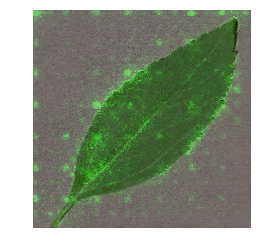

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/interpretdl/interpreter/abc_interpreter.py:175: UserWarning: ``use_cuda`` would be deprecated soon. Use ``device`` directly.
  Interpreter.__init__(self, paddle_model, device, use_cuda, **kwargs)
100%|██████████| 1000/1000 [00:05<00:00, 191.84it/s]


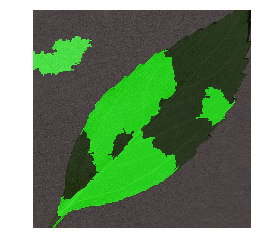

In [90]:
ResNet18_sg = it.SmoothGradInterpreter(ResNet18, use_cuda=True)  #把ResNet18加载到可解释性算法中，这里我们用的是SmoothGrad算法

ResNet18_gradients = ResNet18_sg.interpret("图片/11/2.jpg", visual=True, save_path=None)  #展示结果

ResNet18_sg2 = it.LIMECVInterpreter(ResNet18, use_cuda=True)  #把ResNet18加载到可解释性算法中，这里我们用的是SmoothGrad算法

ResNet18_gradients1 = ResNet18_sg2.interpret("图片/11/2.jpg", visual=True, save_path=None)  #展示结果

# visualize_grayscale(ResNet18_gradients[0])   #将结果转化为灰度图，展示效果更直观

In [97]:
ResNet34_result = [n for n, v in ResNet18.named_sublayers()]
print(ResNet34_result)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.relu', 'layer1.0.downsample', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.relu', 'layer1.2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.relu', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.relu', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.conv3', 'layer2.1.bn3', 'layer2.1.relu', 'layer2.2', 'layer2.2.conv1', 'layer2.2.bn1', 'layer2.2.conv2', 'layer2.2.bn2', 'layer2.2.conv3', 'layer2.2.bn3', 'layer2.2.relu', 'layer2.3', 

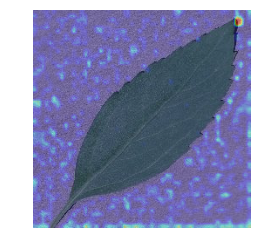

In [94]:
paddle_model = ResNet18

gradcam = it.GradCAMInterpreter(paddle_model, use_cuda=True)

heatmap = gradcam.interpret(
        "图片/11/2.jpg",
        'layer1',
        label=None,
        visual=True,
        save_path=None)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/interpretdl/interpreter/abc_interpreter.py:175: UserWarning: ``use_cuda`` would be deprecated soon. Use ``device`` directly.
  Interpreter.__init__(self, paddle_model, device, use_cuda, **kwargs)
100%|██████████| 1000/1000 [00:05<00:00, 178.23it/s]


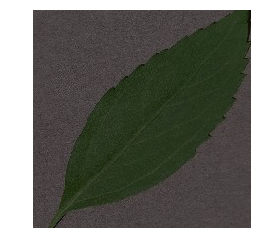

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/interpretdl/interpreter/abc_interpreter.py:83: UserWarning: ``use_cuda`` would be deprecated soon. Use ``device`` directly.
  Interpreter.__init__(self, paddle_model, device, use_cuda, **kwargs)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/varbase_patch_methods.py:382: UserWarning: 
tensor.grad will return the tensor value of the gradient. This is an incompatible upgrade for tensor.grad API.  It's return type changes from numpy.ndarray in version 2.0 to paddle.Tensor in version 2.1.0.  If you want to get the numpy value of the gradient, you can use :code:`x.grad.numpy()` 
  warnings.warn(warning_msg)
  0%|          | 0/50 [00:00<?, ?it/s]100%|███

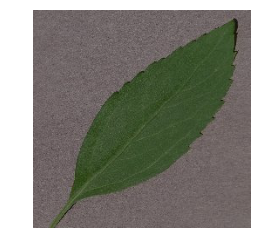

In [95]:
CBAM_ResNet18_sg = it.LIMECVInterpreter(CBAM_ResNet18, use_cuda=True)  #把ResNet18加载到可解释性算法中，这里我们用的是SmoothGrad算法

CBAM_ResNet18_gradients = CBAM_ResNet18_sg.interpret("图片/11/2.jpg", visual=True, save_path=None)  #展示结果

CBAM_ResNet18_sg = it.SmoothGradInterpreter(CBAM_ResNet18, use_cuda=True)  #把ResNet18加载到可解释性算法中，这里我们用的是SmoothGrad算法

CBAM_ResNet18_gradients = CBAM_ResNet18_sg.interpret("图片/11/2.jpg", visual=True, save_path=None)  #展示结果

#  visualize_grayscale(CBAM_ResNet18_gradients[0]) 

In [100]:
CBAM_ResNet18_result = [n for n, v in CBAM_ResNet18.named_sublayers()]
print(CBAM_ResNet18_result)

['conv1', 'bn1', 'relu', 'CBAM_Module1', 'CBAM_Module1.avg_pool', 'CBAM_Module1.max_pool', 'CBAM_Module1.fc1', 'CBAM_Module1.relu', 'CBAM_Module1.fc2', 'CBAM_Module1.sigmoid_channel', 'CBAM_Module1.conv_after_concat', 'CBAM_Module1.sigmoid_spatial', 'maxpool', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.relu', 'layer1.0.downsample', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.relu', 'layer1.2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.relu', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.relu', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'la

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/interpretdl/interpreter/gradient_cam.py:30: UserWarning: ``use_cuda`` would be deprecated soon. Use ``device`` directly.
  Interpreter.__init__(self, paddle_model, device, use_cuda)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/interpretdl/data_processor/visualizer.py:133: RuntimeWarning: invalid value encountered in true_divide
  explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min())


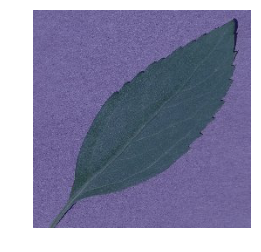

In [96]:
paddle_model = CBAM_ResNet18
#数据集/34分类/leaf_train/1615449235848-4108.jpg
gradcam = it.GradCAMInterpreter(paddle_model, use_cuda=True)

heatmap = gradcam.interpret(
        "图片/11/2.jpg",
        'layer4',
        label=None,
        visual=True,
        save_path=None)

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 